# Exercice 3.1: Expansion planning -- Mon projet

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from linopy import Model

### Loading the data

In [2]:
### Loading the data and convert to xarray DataSet

# Technologies data:
tech_param = pd.read_csv('data/technologies.csv',index_col=0)

# Storages data
sto_param = pd.read_csv("data/storage_technologies.csv", index_col=0).to_xarray()

# Demand:
demand = pd.read_csv('data/demand.csv',index_col=0, sep=";").to_xarray()

# Renewable generation:
AF = pd.read_csv('data/AF_2021.csv',index_col=0, sep=";") # AF is given in the file only for the renewables, we need to add columns for the other technologies.
for tech in tech_param.index:
    if tech not in AF.columns:
        AF.loc[:,tech] = tech_param.loc[tech, "Availability"] 
tech_param = tech_param.to_xarray()

# Global parameters:
general_parameters = pd.read_csv('data/global_parameters.csv',index_col=0)


### Create the Sets and PARAMETERS of the linopy model

In [4]:
### Sets
Time = demand.get_index("Time")
Tech = tech_param.get_index("Technologies")
Sto = sto_param.get_index("Storages")


# Technologies related
TECH_MAX_CAP = tech_param['Maximum capacity']
MARGINAL_FUEL_COST = tech_param['Fuel costs']/tech_param['Rated efficiency']
CO2_INTENSITY = tech_param['Fuel CO2 content']/tech_param['Rated efficiency']
TECH_PHI = tech_param["Discount rate"]/(1-(1+tech_param["Discount rate"])**(-tech_param["Lifetime"]))
TECH_IC = TECH_PHI*tech_param['Investment cost']
DELTA_MAX_UP = tech_param['Ramp-up rate']
DELTA_MAX_DOWN = tech_param['Ramp-down rate']
AF = AF[Tech]
AF  = xr.DataArray(AF,coords=[Time,Tech])
LEGACY = tech_param["Legacy capacity"]


# Storage related
STO_MAX_CAP = sto_param["Maximum capacity"]
STO_PHI = sto_param["Discount rate"]/(1-(1+sto_param["Discount rate"])**(-sto_param["Lifetime"]))
STO_IC = STO_PHI*sto_param["Investment cost"]
EFF_D = sto_param["Discharge efficiency"]
EFF_C = sto_param["Charge efficiency"]
SOC_MAX = sto_param["Maximum state of charge"]
SOC_MIN = sto_param["Minimum state of charge"]
STO_dT = sto_param["Storage duration"]


# Configuration and scenario parameters
DEMAND = demand["Demand"]
DEMAND = DEMAND/1e3               # Demand [MWh/h]
TS = float(general_parameters.Value.loc['Time step'])
VOLL = float(general_parameters.Value.loc['VOLL'])
CO2_PRICE = float(general_parameters.Value.loc['CO2_price'])
CO2_BOUND = float(general_parameters.Value.loc['CO2_bound'])

IMPORT_COST = 74.24 
CO2_IMPORT = 0.3
IMPORT_MAX_CAP = 30000
EXPORT_MAX_CAP = 30000
EXPORT_PRICE = 20


### Write the optimization model (variables, constraints and objective function)

In [6]:
### Create the model instance

m = Model()

### Create the variables

cap_tech = m.add_variables(lower = 0, coords = [Tech], name = 'cap_tech') # Installed capacity of the technologies [MW]
g = m.add_variables(lower = 0, coords = [Tech, Time], name = 'g')        # Generated power [MW]
fcd = m.add_variables(lower = 0, coords = [Tech, Time], name = 'fcd')    # Fuel cost definition [EUR/h]

cap_sto = m.add_variables(lower = 0, coords = [Sto], name = 'cap_sto') # Installed capacity of the storages [MW]
sd = m.add_variables(lower = 0, coords = [Sto, Time], name = 'sd')     # Storage discharge [MW]
sc = m.add_variables(lower = 0, coords = [Sto, Time], name = 'sc')     # Storage charge [MW]
se = m.add_variables(lower = 0, coords = [Sto, Time], name = 'se')     # Stored energy [MWh]

co2_emissions =  m.add_variables(lower = 0, name = 'co2_emissions')     # Combined CO2 emissions [tCO2eq]
ens = m.add_variables(lower = 0, coords = [Time], name = 'ens')           # Energy no served [MWh]

curt = m.add_variables(lower = 0, coords = [Time])                      # Curtailment [MWh]

import_grid = m.add_variables(lower = 0, coords = [Time])            # power import from the national grid 
export_grid = m.add_variables(lower = 0, coords = [Time])            # power export to the national grid 


# Create the constraints

# Technology sizing
cap_max_tech = m.add_constraints(cap_tech <= TECH_MAX_CAP, name = "cap_max_tech")
power_max = m.add_constraints(g <= AF*cap_tech, name= 'power_max')

# Ramping up/down constraints
power_rampup_initial = m.add_constraints(g.loc[:,:Time[0]] - g.loc[:,Time[len(Time)-1]:] <= DELTA_MAX_UP*cap_tech , name = 'power_rampup_initial')
power_rampup = m.add_constraints(g.loc[:, Time[1:]] <= g.shift(Time = 1) + DELTA_MAX_UP*cap_tech, name = 'power_rampup')

power_rampdown_initial = m.add_constraints(g.loc[:,:Time[0]] - g.loc[:,Time[len(Time)-1]:]  >= - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown_initial')
power_rampdown = m.add_constraints(g.loc[:, Time[1:]]>= g.shift(Time = 1) - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown')


# Storage sizing + Initial condition
cap_max_sto = m.add_constraints(cap_sto <= STO_MAX_CAP, name = "cap_max_sto")
storage_initial_state = m.add_constraints(se.loc[:,:Time[0]] - se.loc[:,Time[len(Time)-1]:]  == TS*EFF_C*sc.loc[:,Time[len(Time)-1]:] - TS*sd.loc[:,Time[len(Time)-1]:]/EFF_D, name = 'storage_initial_state')
storage_balance = m.add_constraints(se.loc[:,Time[1:]] - se.shift(Time = 1) == TS*EFF_C*sc.loc[:,Time[1:]] -TS*sd.loc[:,Time[1:]]/EFF_D, name = 'storage_balance')
storage_charge_max = m.add_constraints(sc <= cap_sto/STO_dT, name = 'storage_charge_max')
storage_discharge_max = m.add_constraints(sd <= cap_sto/STO_dT, name = 'storage_discharge_max')
storage_energy_max = m.add_constraints(se <= SOC_MAX*cap_sto, name = 'storage_energy_max' )
storage_energy_min = m.add_constraints(se >= SOC_MIN*cap_sto, name = 'storage_energy_min' )

# Grid import
cap_max_import = m.add_constraints(import_grid <= IMPORT_MAX_CAP, name = "cap_max_import")
cap_max_export = m.add_constraints(export_grid <= EXPORT_MAX_CAP, name = "cap_max_export")

# Market clearing
mcc = m.add_constraints(g.sum(dims = 'Technologies') + ens + (sd - sc).sum(dims = "Storages") + import_grid - export_grid == DEMAND, name = 'mcc') #

# Limit on energy not served
ens_lim = m.add_constraints(ens<=DEMAND, name = 'ens_lim')

# Costs
fuel_cost = m.add_constraints(fcd == MARGINAL_FUEL_COST*g , name="fuel_cost")

# CO2 Emissions
co2_account =  m.add_constraints(co2_emissions == (CO2_INTENSITY*g).sum(dims=["Technologies", "Time"]) + (CO2_IMPORT*import_grid).sum(dim="Time") , name="co2 account") # + (CO2_IMPORT*import_grid).sum(dim="Time")
co2_bound = m.add_constraints(co2_emissions <= CO2_BOUND, name = "co2_bound")

### Curtailment evaluation.
RE_MASK = xr.DataArray(np.array([1,1]), coords = [Tech])
curt_eval = m.add_constraints(curt == ((AF*cap_tech-g)*RE_MASK).sum(dims = 'Technologies') , name = 'curt')

# Add the objective function
total_cost = (TECH_IC*cap_tech).sum(dim="Technologies") + (STO_IC*cap_sto).sum(dim="Storages") + (TS*fcd).sum(dims = ['Technologies', 'Time']) + (VOLL*TS*ens).sum(dim ='Time') + (IMPORT_COST*import_grid).sum(dim ='Time') - (EXPORT_PRICE*export_grid).sum(dim ='Time') 

m.add_objective(total_cost)

### Solve

In [7]:
m.solve("gurobi")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551043
Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be


Writing continuous variables.: 100%|██████████| 12/12 [00:00<00:00, 109.06it/s]


Read LP format model from file /tmp/linopy-problem-eh477y7o.lp
Reading time = 0.23 seconds
obj: 157689 rows, 96364 columns, 394017 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 157689 rows, 96364 columns and 394017 nonzeros
Model fingerprint: 0x4625346d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+04]
Presolve removed 70458 rows and 37765 columns
Presolve time: 0.40s
Presolved: 87231 rows, 58599 columns, 315950 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 Dense

('ok', 'optimal')

## Post-process

LCOE= 49.40 euro/MWh


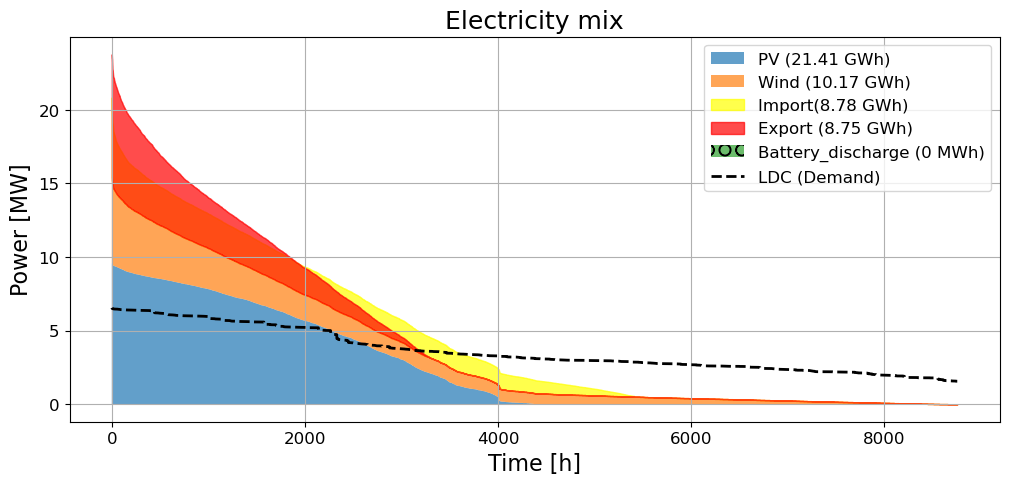

Power installed of wind :  7.13 MW
Power installed of PV : 12.86 MW
Power installed of battery : 0.00 MW


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Demand
sorted_demand = DEMAND.values.flatten()
sorted_demand = pd.Series(sorted_demand).sort_values(ascending=False)

# Technology
generation_df = g.solution.to_dataframe().unstack(level=0)
generation_df.columns = generation_df.columns.droplevel(0)

# Storage
charge_df = sc.solution.to_dataframe()["solution"].unstack(level=0)
charge_df["Battery"] = sorted(charge_df["Battery"].values, reverse=True)

discharge_df = sd.solution.to_dataframe()["solution"].unstack(level=0)
discharge_df["Battery"] = sorted(discharge_df["Battery"].values, reverse=True)

# Import 
import_series = import_grid.solution.to_series()
#generation_df["Grid Import"] = import_series.values
import_series = sorted(import_series.values, reverse=True)

# Export 
export_series = export_grid.solution.to_series()
####generation_df["Grid Export"] = export_series.values
export_series = sorted(export_series.values, reverse=True)

total_production = generation_df.sum()
sorted_columns = total_production.sort_values(ascending=False).index
generation_df = generation_df[sorted_columns]
generation_df = generation_df.apply(lambda x: x.sort_values(ascending=False).values, axis=0)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

bottom_stack = np.zeros(8760)
for column in generation_df.columns:
    energy_gwh = generation_df[column].sum()/1000
    label_with_energy = f"{column} ({energy_gwh:.2f} GWh)"
    ax1.fill_between(range(8760), bottom_stack, bottom_stack + generation_df[column],
                     label=label_with_energy, alpha=0.7)
    bottom_stack += generation_df[column]

ax1.fill_between(range(8760), bottom_stack, bottom_stack + import_series, label=f"Import({import_grid.solution.sum().item()/1e3:.2f} GWh)", alpha=0.7, color='yellow')

ax1.fill_between(range(8760), bottom_stack, bottom_stack + export_series, label=f"Export ({export_grid.solution.sum().item()/1e3:.2f} GWh)", alpha=0.7, color='red')
bottom_stack += export_series 

#ax1.fill_between(range(8760), bottom_stack, bottom_stack + charge_df["Battery"], label=f"Battery_charge ({sc.solution.sum().item():.0f} MWh)", alpha=0.7, hatch="o")
ax1.fill_between(range(8760), np.zeros(8760), discharge_df["Battery"], label=f"Battery_discharge ({sd.solution.sum().item():.0f} MWh)", alpha=0.7, hatch="O")

ax1.plot(sorted_demand.values, label="LDC (Demand)", color='black', linestyle='--', linewidth=2)
ax1.set_xlabel("Time [h]", fontsize = 16)
ax1.set_ylabel("Power [MW]", fontsize = 16)
ax1.set_title("Electricity mix", fontsize = 18)
ax1.grid(True)
ax1.legend(loc="upper right", fontsize= 12)
ax1.tick_params(axis='both', labelsize=12)
#plt.savefig("part1.png", format="png")
fig.savefig('part1.png', dpi=300, transparent=True)
print('LCOE= %.2f euro/MWh' %(total_cost.solution.sum()/DEMAND.sum().values))
plt.show()



print("Power installed of wind :  %.2f MW"%  cap_tech.solution.values[0])
print("Power installed of PV : %.2f MW"% cap_tech.solution.values[1])
print("Power installed of battery : %.2f MW"% cap_sto.solution.values[0])

In [14]:
print(f"g = {g.solution.sum().values:.0f} kW")
print(f"Import = {import_grid.solution.sum().values:.0f} kW")
print(f"Ens = { ens.solution.sum().values:.0f} kW")
print(f"Curt = {curt.solution.sum().values:.0f} kW")
print(f"sd = {sd.solution.sum().values:.0f} kW")
print(f"sc = {sc.solution.sum().values:.0f} kW")
print(f"Export = { export_grid.solution.sum().values:.0f} kW")

print(f"DEMAND = { DEMAND.sum().values:.0f} kW")
print(g.solution.sum().values + ens.solution.sum().values + (sd.solution.sum().values - sc.solution.sum().values)+ import_grid.solution.sum().values)#- export_grid

g = 31575 kW
Import = 8784 kW
Ens = 0 kW
Curt = 0 kW
sd = 0 kW
sc = 0 kW
Export = 8749 kW
DEMAND = 31610 kW
40359.063131962175


<Axes: xlabel='Technologies'>

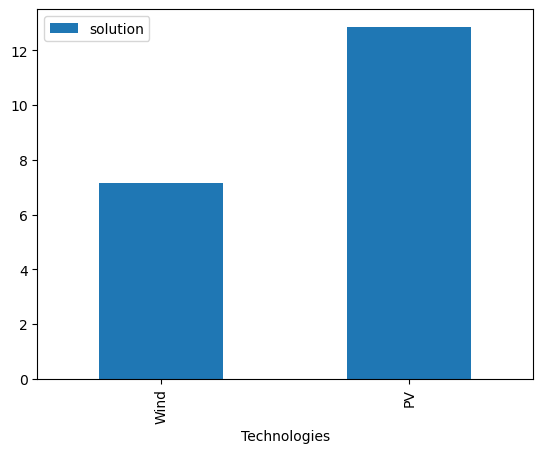

In [15]:
cap_tech.solution.to_dataframe().plot(kind="bar")


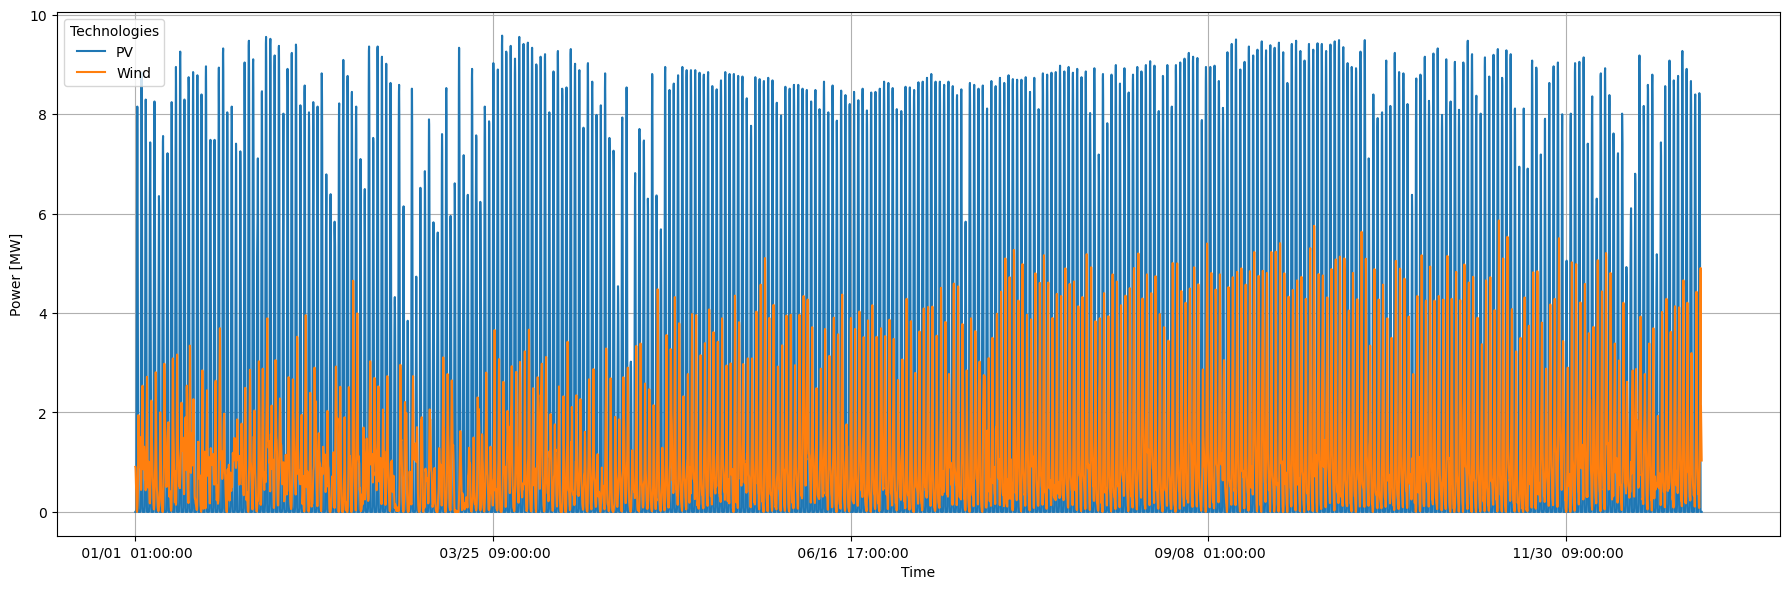

In [16]:
#se.solution.to_dataframe().reset_index().pivot(index="Time", columns="Storages", values="solution").plot()
import matplotlib.pyplot as plt
                    
g_df = g.solution.to_dataframe().reset_index().pivot(index="Time", columns="Technologies", values="solution")
g_df.plot(figsize=(18, 6))  # ← augmente la largeur (18) et ajuste la hauteur (6)
plt.xlabel("Time")
plt.ylabel("Power [MW]")
#plt.title("Storage Energy Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

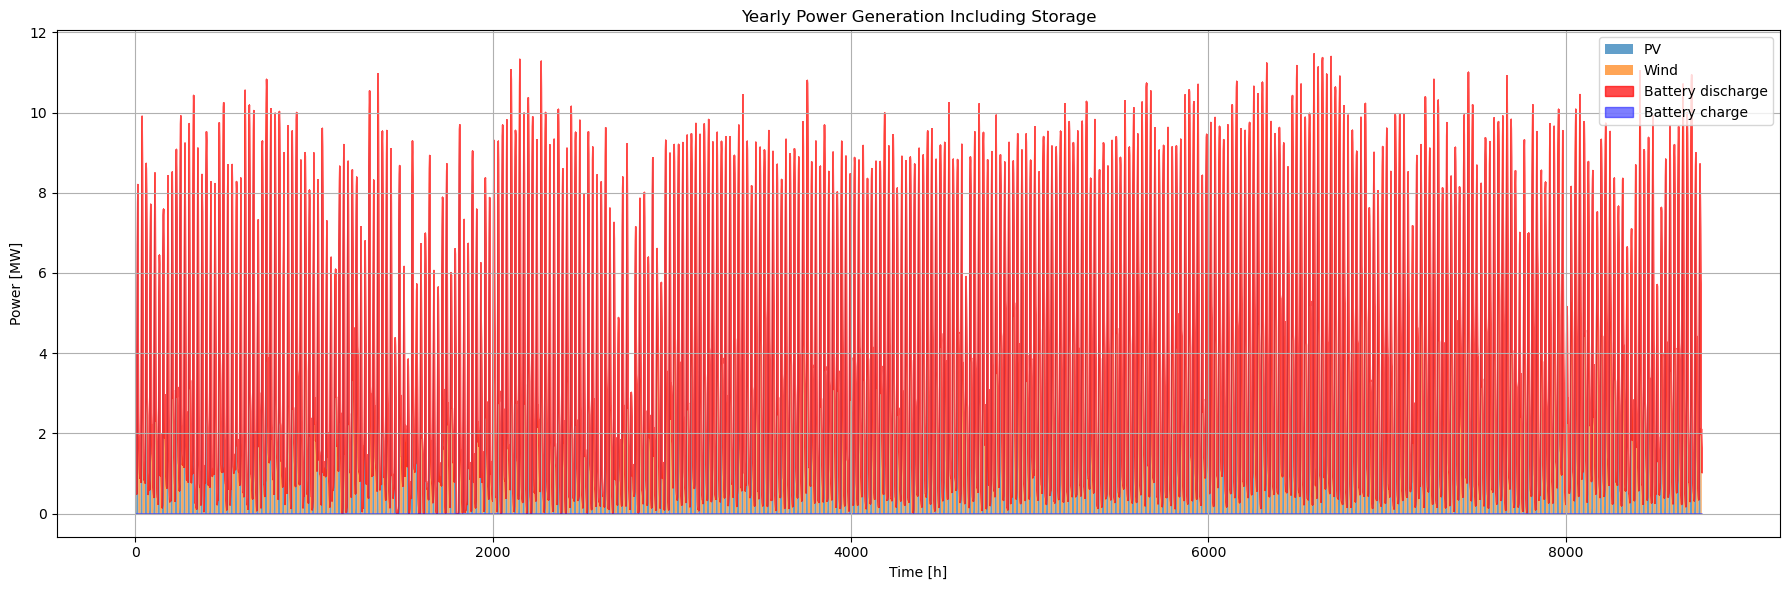

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Génération
generation_df = g.solution.to_dataframe().unstack(level=0)
generation_df.columns = generation_df.columns.droplevel(0)

# 2. Tri des colonnes
total_production = generation_df.sum()
sorted_columns = total_production.sort_values(ascending=False).index
generation_df = generation_df[sorted_columns]

# 3. Charge / décharge (alignés sur le temps)
charge_df = sc.solution.to_dataframe()["solution"].unstack(level=0).fillna(0)
discharge_df = sd.solution.to_dataframe()["solution"].unstack(level=0).fillna(0)

# 4. Addition d'une courbe empilée pour la décharge (comme source de prod)
bottom_stack = np.zeros(len(generation_df))

plt.figure(figsize=(18, 6))
for column in generation_df.columns:
    plt.fill_between(range(len(generation_df)), bottom_stack, bottom_stack + generation_df[column], label=column, alpha=0.7)
    bottom_stack += generation_df[column]

# 5. Ajouter la décharge comme "Battery discharge"
total_discharge = discharge_df.sum(axis=1)
plt.fill_between(range(len(total_discharge)), bottom_stack, bottom_stack + total_discharge, label="Battery discharge", alpha=0.7, color='red')
bottom_stack += total_discharge

# 6. Ajouter la charge (en dessous de zéro)
total_charge = charge_df.sum(axis=1)
plt.fill_between(range(len(total_charge)), 0, -total_charge, label="Battery charge", alpha=0.5, color='blue')

# 7. Plot settings
plt.xlabel("Time [h]")
plt.ylabel("Power [MW]")
plt.title("Yearly Power Generation Including Storage")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Data visualization with hvplot

In [ ]:
import hvplot.xarray
import hvplot.pandas
import panel as pn
import panel.widgets as pnw

In [ ]:
p1 = (-1)*sc.solution.sum(dim = "Storages")
p1 = p1.hvplot.line(x = 'Time',color = 'red', rot = 90, width = 1200, height = 1000)
p3 = sd.solution.sum(dim = "Storages").hvplot.line(x = 'Time',color = 'blue')

p2 = g.solution.hvplot.area(x = 'Time',by = 'Technologies', stacked = True, alpha = 0.5)
p4 = demand.hvplot.line(x = 'Time', color = 'black')
#p5 = (g.solution.sum(dim = 'Technologies') + GWIND + GSOLAR).rename('RE')
#p5 = p5.hvplot.area(alpha = 0.3, color = 'gold',width = 800, height = 500)
(p1*p2*p3*p4)

In [ ]:
gen = m.solution.g.round(0).to_dataframe().reset_index()
table = pd.pivot_table(gen, values='g', index=['Time'],
                       columns=['Technologies'], aggfunc="sum")
table.hvplot.area(x = 'Time', y = table.columns.to_list(), stacked = True, alpha  = 0.4, height = 500, width = 1000)
table.hvplot(x = 'Time', kind = 'bar', stacked = True, rot = 90, width =1000, height=500, alpha  = 0.6)
#data.close()